# Persiapan


In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


In [2]:
path = "/content/drive/MyDrive/UAP ML/GENSHIN COMMENT.csv"
df = pd.read_csv(path)

df.head(), df.shape


(          userName  score                  at  \
 0  Pengguna Google      4  2025-03-14 4:18:23   
 1  Pengguna Google      2  2025-03-14 4:15:34   
 2  Pengguna Google      1  2025-03-14 4:07:15   
 3  Pengguna Google      5  2025-03-14 4:01:07   
 4  Pengguna Google      5  2025-03-14 3:13:43   
 
                                              content  
 0  Gem nya sangat bagus tetapi soal gaca nya mala...  
 1  Kapan support gamepad versi android 😭😭 Males m...  
 2     woii furina gw mana udah pity 76 blom dapat b5  
 3                                             Baguss  
 4               Game yang sangat menghibur dan bagus  ,
 (215176, 4))

In [3]:
df = df[["content", "score"]]
df.head()


,content,score
0,Gem nya sangat bagus tetapi soal gaca nya mala...,4
1,Kapan support gamepad versi android 😭😭 Males m...,2
2,woii furina gw mana udah pity 76 blom dapat b5,1
3,Baguss,5
4,Game yang sangat menghibur dan bagus,5


# PROCESSING

In [ ]:
def label_sentiment(score):
    if score >= 4:
        return "positif"
    elif score == 3:
        return "netral"
    else:
        return "negatif"

df["label"] = df["score"].apply(label_sentiment)
df.head()


,content,score,label
0,Gem nya sangat bagus tetapi soal gaca nya mala...,4,positif
1,Kapan support gamepad versi android 😭😭 Males m...,2,negatif
2,woii furina gw mana udah pity 76 blom dapat b5,1,negatif
3,Baguss,5,positif
4,Game yang sangat menghibur dan bagus,5,positif


Cleaning Text

In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["content"] = df["content"].apply(clean_text)

# hapus kosong
df = df[df["content"].str.len() > 3]

df.shape


(207113, 3)

AMBIL SUBSET

In [ ]:
df_sample = df.groupby("label").apply(
    lambda x: x.sample(n=5000, random_state=42)
).reset_index(drop=True)

df_sample["label"].value_counts()


/tmp/ipython-input-460995124.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby("label").apply(


,count
label,
negatif,5000
netral,5000
positif,5000


SIMPAN DATASET HASIL LABEL

In [ ]:
save_path = "/content/drive/MyDrive/UAP ML/genshin_sentiment_labeled.csv"
df_sample[["content", "label"]].to_csv(save_path, index=False)

save_path


'/content/drive/MyDrive/UAP ML/genshin_sentiment_labeled.csv'

ENCODE LABEL

In [ ]:
le = LabelEncoder()
df_sample["label_encoded"] = le.fit_transform(df_sample["label"])

le.classes_


array(['negatif', 'netral', 'positif'], dtype=object)

TRAIN TEST SPLIT

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_sample["content"].tolist(),
    df_sample["label_encoded"].values,
    test_size=0.2,
    random_state=42,
    stratify=df_sample["label_encoded"]
)


# TRAINING BERT

In [21]:
import pandas as pd

path = "/content/drive/MyDrive/UAP ML/genshin_sentiment_labeled.csv"
df = pd.read_csv(path)

df.head(), df.shape


(                                             content    label
 0                              internet problem ping  negatif
 1  hahhahaa sukurin kan rate nya anjlok lg pelit ...  negatif
 2                                    pw spiral abyss  negatif
 3                                     pelit aniv nya  negatif
 4                                         game bocil  negatif,
 (15000, 2))

Encode Label

In [22]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])

le.classes_


array(['negatif', 'netral', 'positif'], dtype=object)

Train Test Split

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df["content"].tolist(),
    df["label_encoded"].values,
    test_size=0.2,
    random_state=42,
    stratify=df["label_encoded"]
)


Load Tokenizer & Model

In [24]:
from transformers import BertTokenizerFast, BertForSequenceClassification

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3
)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
train_encodings = tokenizer(
    X_train,
    truncation=True,
    padding=True,
    max_length=128
)

test_encodings = tokenizer(
    X_test,
    truncation=True,
    padding=True,
    max_length=128
)


In [26]:
import torch

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, y_train)
test_dataset  = SentimentDataset(test_encodings, y_test)


In [27]:
import numpy as np
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds)
    }


Training BERT

In [28]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./bert_output",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


trainer.train()


/tmp/ipython-input-85311973.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.934900,0.853003,0.609000
2,0.752200,0.856952,0.622667


TrainOutput(global_step=1500, training_loss=0.8313152872721354, metrics={'train_runtime': 592.6674, 'train_samples_per_second': 40.495, 'train_steps_per_second': 2.531, 'total_flos': 1578680506368000.0, 'train_loss': 0.8313152872721354, 'epoch': 2.0})

=== Classification Report ===
              precision    recall  f1-score   support

     negatif       0.63      0.47      0.53      1000
      netral       0.51      0.69      0.58      1000
     positif       0.75      0.67      0.71      1000

    accuracy                           0.61      3000
   macro avg       0.63      0.61      0.61      3000
weighted avg       0.63      0.61      0.61      3000



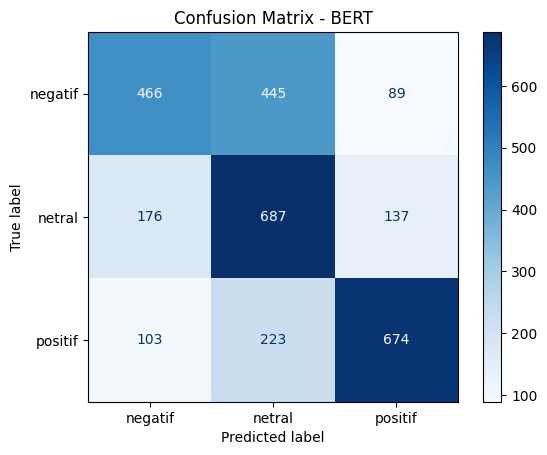

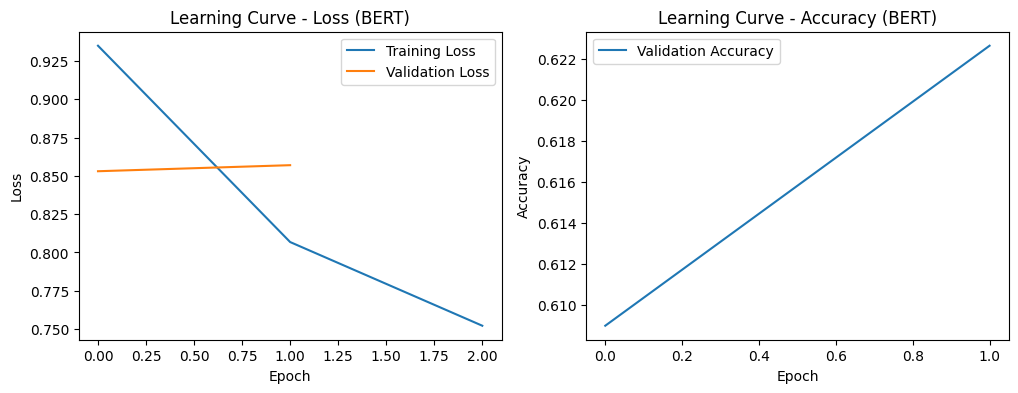

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# ===============================
# PREDIKSI
# ===============================
preds = trainer.predict(test_dataset)
y_pred = np.argmax(preds.predictions, axis=1)

# ===============================
# 1. CLASSIFICATION REPORT
# ===============================
print("=== Classification Report ===")
print(classification_report(
    y_test,
    y_pred,
    target_names=le.classes_
))

# ===============================
# 2. CONFUSION MATRIX
# ===============================
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - BERT")  # ganti nama model
plt.show()

# ===============================
# 3. GRAFIK LOSS & ACCURACY
# ===============================
log_history = trainer.state.log_history

train_loss = []
eval_loss = []
eval_accuracy = []

for log in log_history:
    if "loss" in log and "eval_loss" not in log:
        train_loss.append(log["loss"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
    if "eval_accuracy" in log:
        eval_accuracy.append(log["eval_accuracy"])

plt.figure(figsize=(12,4))

# LOSS
plt.subplot(1,2,1)
plt.plot(train_loss, label="Training Loss")
plt.plot(eval_loss, label="Validation Loss")
plt.title("Learning Curve - Loss (BERT)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# ACCURACY
plt.subplot(1,2,2)
plt.plot(eval_accuracy, label="Validation Accuracy")
plt.title("Learning Curve - Accuracy (BERT)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


In [ ]:
model.save_pretrained("/content/drive/MyDrive/UAP ML/bert_genshin_model")
tokenizer.save_pretrained("/content/drive/MyDrive/UAP ML/bert_genshin_model")


('/content/drive/MyDrive/UAP ML/bert_genshin_model/tokenizer_config.json',
 '/content/drive/MyDrive/UAP ML/bert_genshin_model/special_tokens_map.json',
 '/content/drive/MyDrive/UAP ML/bert_genshin_model/vocab.txt',
 '/content/drive/MyDrive/UAP ML/bert_genshin_model/added_tokens.json',
 '/content/drive/MyDrive/UAP ML/bert_genshin_model/tokenizer.json')

# TRAINING LSTM


In [ ]:
import pandas as pd

path = "/content/drive/MyDrive/UAP ML/genshin_sentiment_labeled.csv"
df = pd.read_csv(path)

df.head(), df.shape


(                                             content    label
 0                              internet problem ping  negatif
 1  hahhahaa sukurin kan rate nya anjlok lg pelit ...  negatif
 2                                    pw spiral abyss  negatif
 3                                     pelit aniv nya  negatif
 4                                         game bocil  negatif,
 (15000, 2))

Encode Label

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])

le.classes_


array(['negatif', 'netral', 'positif'], dtype=object)

Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df["content"],
    df["label_encoded"],
    test_size=0.2,
    random_state=42,
    stratify=df["label_encoded"]
)


Tokenization

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_VOCAB = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post")
X_test_pad  = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post")


Model LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model_lstm = Sequential([
    Embedding(MAX_VOCAB, 128, input_length=MAX_LEN),
    LSTM(
        128,
        activation="tanh",
        recurrent_activation="sigmoid",
        dropout=0.2,
        recurrent_dropout=0.2   # ⬅️ INI YANG MEMATIKAN CuDNN
    ),
    Dense(3, activation="softmax")
])

model_lstm.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_lstm.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Training LSTM

In [ ]:
history = model_lstm.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=5,
    batch_size=64
)


Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 74s 346ms/step - accuracy: 0.3336 - loss: 1.1011 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 344ms/step - accuracy: 0.3280 - loss: 1.0991 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 345ms/step - accuracy: 0.3280 - loss: 1.0990 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 341ms/step - accuracy: 0.3314 - loss: 1.0989 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 343ms/step - accuracy: 0.3309 - loss: 1.0989 - val_accuracy: 0.3333 - val_loss: 1.0986


94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step
=== Classification Report ===
              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00      1000
      Others       0.00      0.00      0.00      1000
     Positif       0.33      1.00      0.50      1000

    accuracy                           0.33      3000
   macro avg       0.11      0.33      0.17      3000
weighted avg       0.11      0.33      0.17      3000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


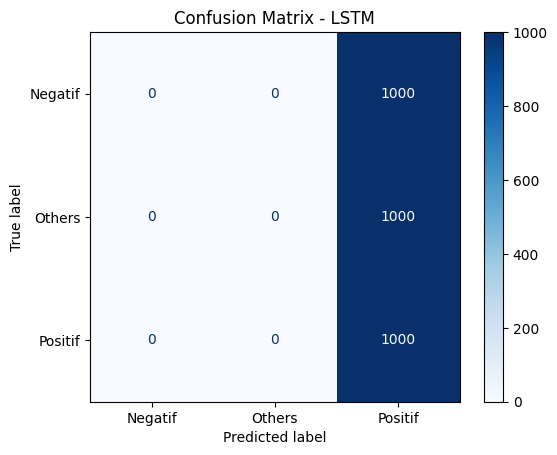

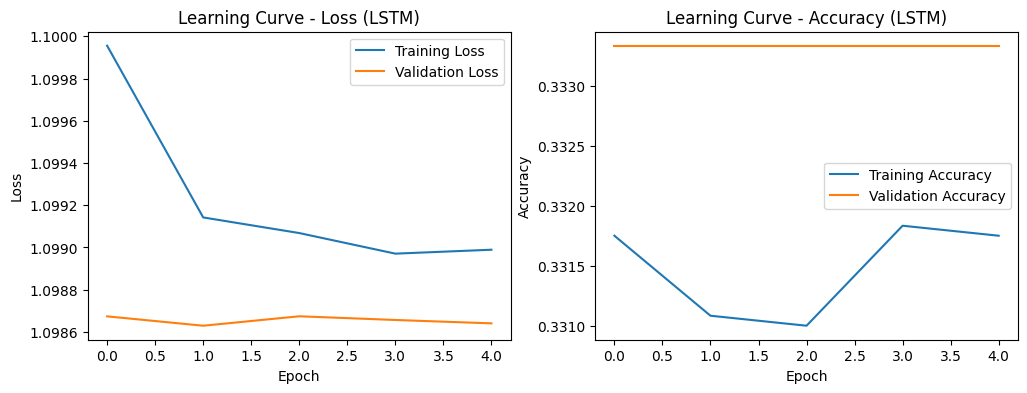

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# ===============================
# PREDIKSI
# ===============================
y_pred = np.argmax(model_lstm.predict(X_test_pad), axis=1)


# ===============================
# 1. CLASSIFICATION REPORT
# ===============================
print("=== Classification Report ===")
print(classification_report(
    y_test,
    y_pred,
    target_names=["Negatif", "Others", "Positif"]
))

# ===============================
# 2. CONFUSION MATRIX
# ===============================
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Negatif", "Others", "Positif"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - LSTM")
plt.show()

# ===============================
# 3. GRAFIK LOSS & ACCURACY
# ===============================
plt.figure(figsize=(12,4))

# LOSS
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Learning Curve - Loss (LSTM)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# ACCURACY
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Learning Curve - Accuracy (LSTM)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()



In [ ]:
model_lstm.save("/content/drive/MyDrive/UAP ML/lstm_genshin_model.keras")


# TRAINING INDOBERT

In [4]:
import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


In [5]:
path = "/content/drive/MyDrive/UAP ML/genshin_sentiment_labeled.csv"
df = pd.read_csv(path)

df.head(), df.shape


(                                             content    label
 0                              internet problem ping  negatif
 1  hahhahaa sukurin kan rate nya anjlok lg pelit ...  negatif
 2                                    pw spiral abyss  negatif
 3                                     pelit aniv nya  negatif
 4                                         game bocil  negatif,
 (15000, 2))

In [6]:
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])
le.classes_


array(['negatif', 'netral', 'positif'], dtype=object)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df["content"].tolist(),
    df["label_encoded"].values,
    test_size=0.2,
    random_state=42,
    stratify=df["label_encoded"]
)


In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_NAME = "indobenchmark/indobert-base-p1"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
train_encodings = tokenizer(
    X_train,
    truncation=True,
    padding=True,
    max_length=128
)

test_encodings = tokenizer(
    X_test,
    truncation=True,
    padding=True,
    max_length=128
)


In [11]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, y_train)
test_dataset  = SentimentDataset(test_encodings, y_test)


In [15]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": accuracy_score(labels, preds)}


In [16]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./indobert_output",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


/tmp/ipython-input-2833069822.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.828400,0.803862,0.637667
2,0.624300,0.822548,0.652333


TrainOutput(global_step=1500, training_loss=0.7201722412109375, metrics={'train_runtime': 589.1391, 'train_samples_per_second': 40.737, 'train_steps_per_second': 2.546, 'total_flos': 1578680506368000.0, 'train_loss': 0.7201722412109375, 'epoch': 2.0})

=== Classification Report ===
              precision    recall  f1-score   support

     negatif       0.65      0.56      0.60      1000
      netral       0.54      0.65      0.59      1000
     positif       0.76      0.70      0.73      1000

    accuracy                           0.64      3000
   macro avg       0.65      0.64      0.64      3000
weighted avg       0.65      0.64      0.64      3000



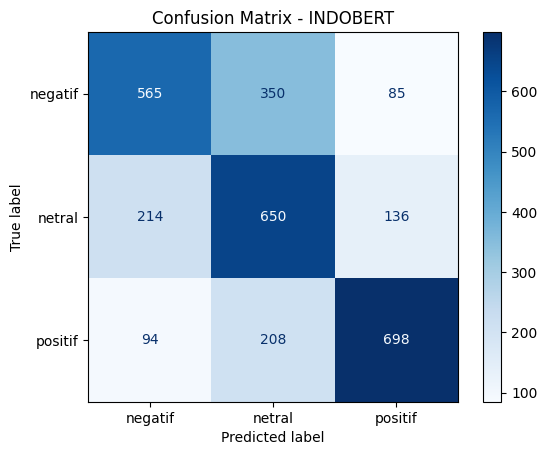

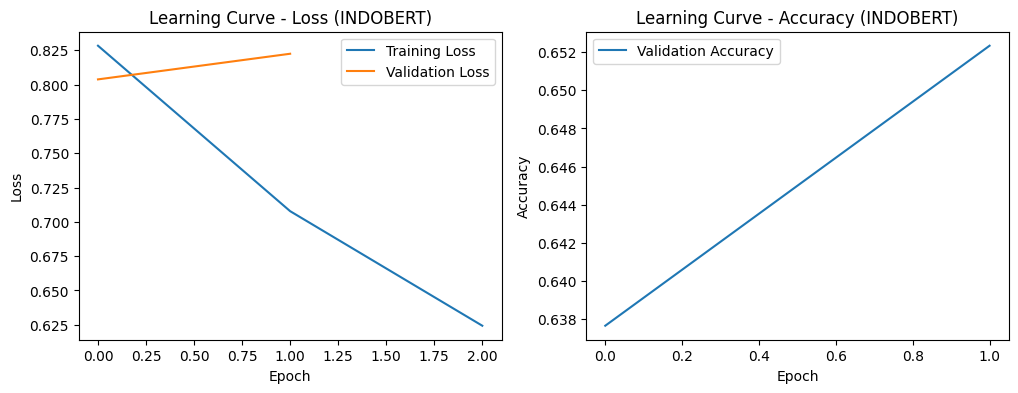

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# ===============================
# PREDIKSI
# ===============================
preds = trainer.predict(test_dataset)
y_pred = np.argmax(preds.predictions, axis=1)

# ===============================
# 1. CLASSIFICATION REPORT
# ===============================
print("=== Classification Report ===")
print(classification_report(
    y_test,
    y_pred,
    target_names=le.classes_
))

# ===============================
# 2. CONFUSION MATRIX
# ===============================
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - INDOBERT")  # ganti nama model
plt.show()

# ===============================
# 3. GRAFIK LOSS & ACCURACY
# ===============================
log_history = trainer.state.log_history

train_loss = []
eval_loss = []
eval_accuracy = []

for log in log_history:
    if "loss" in log and "eval_loss" not in log:
        train_loss.append(log["loss"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
    if "eval_accuracy" in log:
        eval_accuracy.append(log["eval_accuracy"])

plt.figure(figsize=(12,4))

# LOSS
plt.subplot(1,2,1)
plt.plot(train_loss, label="Training Loss")
plt.plot(eval_loss, label="Validation Loss")
plt.title("Learning Curve - Loss (INDOBERT)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# ACCURACY
plt.subplot(1,2,2)
plt.plot(eval_accuracy, label="Validation Accuracy")
plt.title("Learning Curve - Accuracy (INDOBERT)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


In [20]:
save_dir = "/content/drive/MyDrive/UAP ML/indobert_genshin_model"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

save_dir


'/content/drive/MyDrive/UAP ML/indobert_genshin_model'

# TRAINING DISTILBERT

In [30]:
import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


In [31]:
path = "/content/drive/MyDrive/UAP ML/genshin_sentiment_labeled.csv"
df = pd.read_csv(path)
df.head(), df.shape


(                                             content    label
 0                              internet problem ping  negatif
 1  hahhahaa sukurin kan rate nya anjlok lg pelit ...  negatif
 2                                    pw spiral abyss  negatif
 3                                     pelit aniv nya  negatif
 4                                         game bocil  negatif,
 (15000, 2))

In [32]:
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])
le.classes_


array(['negatif', 'netral', 'positif'], dtype=object)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    df["content"].tolist(),
    df["label_encoded"].values,
    test_size=0.2,
    random_state=42,
    stratify=df["label_encoded"]
)


In [34]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_NAME = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3
)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
train_encodings = tokenizer(
    X_train,
    truncation=True,
    padding=True,
    max_length=128
)

test_encodings = tokenizer(
    X_test,
    truncation=True,
    padding=True,
    max_length=128
)


In [36]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, y_train)
test_dataset  = SentimentDataset(test_encodings, y_test)


In [37]:
import numpy as np
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds)
    }


In [38]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./distilbert_output",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


/tmp/ipython-input-4247120924.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.854462,0.599333
2,0.864600,0.851290,0.616000


TrainOutput(global_step=750, training_loss=0.8226426391601562, metrics={'train_runtime': 354.6404, 'train_samples_per_second': 67.674, 'train_steps_per_second': 2.115, 'total_flos': 794818566144000.0, 'train_loss': 0.8226426391601562, 'epoch': 2.0})

=== Classification Report ===
              precision    recall  f1-score   support

     negatif       0.62      0.55      0.58      1000
      netral       0.53      0.58      0.55      1000
     positif       0.71      0.72      0.72      1000

    accuracy                           0.62      3000
   macro avg       0.62      0.62      0.62      3000
weighted avg       0.62      0.62      0.62      3000



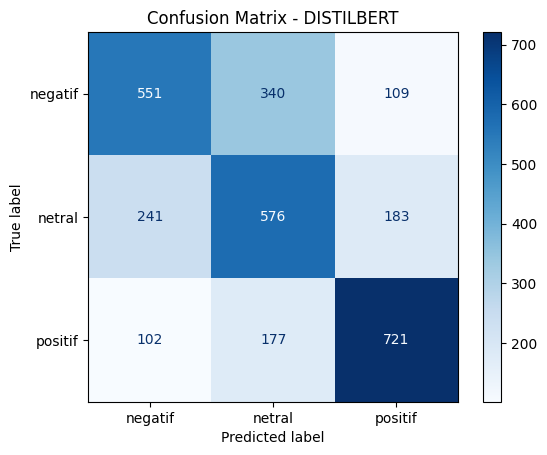

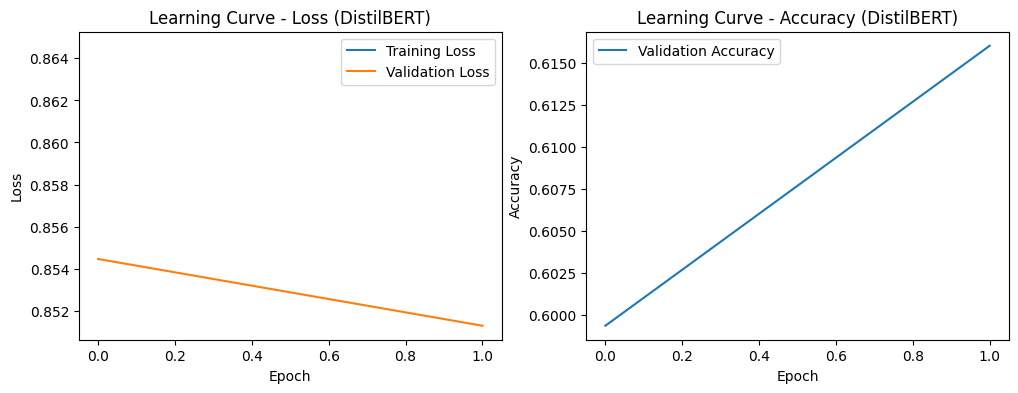

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# ===============================
# PREDIKSI
# ===============================
preds = trainer.predict(test_dataset)
y_pred = np.argmax(preds.predictions, axis=1)

# ===============================
# 1. CLASSIFICATION REPORT
# ===============================
print("=== Classification Report ===")
print(classification_report(
    y_test,
    y_pred,
    target_names=le.classes_
))

# ===============================
# 2. CONFUSION MATRIX
# ===============================
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - DISTILBERT")  # ganti nama model
plt.show()

# ===============================
# 3. GRAFIK LOSS & ACCURACY
# ===============================
log_history = trainer.state.log_history

train_loss = []
eval_loss = []
eval_accuracy = []

for log in log_history:
    if "loss" in log and "eval_loss" not in log:
        train_loss.append(log["loss"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
    if "eval_accuracy" in log:
        eval_accuracy.append(log["eval_accuracy"])

plt.figure(figsize=(12,4))

# LOSS
plt.subplot(1,2,1)
plt.plot(train_loss, label="Training Loss")
plt.plot(eval_loss, label="Validation Loss")
plt.title("Learning Curve - Loss (DistilBERT)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# ACCURACY
plt.subplot(1,2,2)
plt.plot(eval_accuracy, label="Validation Accuracy")
plt.title("Learning Curve - Accuracy (DistilBERT)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


In [40]:
save_dir = "/content/drive/MyDrive/UAP ML/distilbert_genshin_model"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

save_dir


'/content/drive/MyDrive/UAP ML/distilbert_genshin_model'